Load necessary packages

In [1]:
using Zygote
using Plots
using LaTeXStrings

Define sigmoid and its derivative, plot them

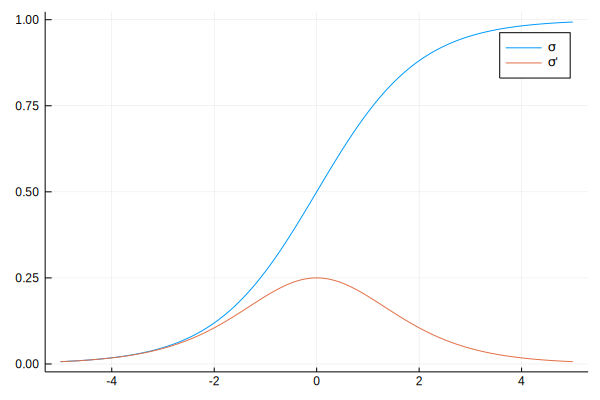

In [2]:
function sigmoid(x)
    return 1.0/(1.0+exp(-x))
end

function sigm_der(x)
    return sigmoid(x)*(1.0-sigmoid(x))
end

x = collect(-5:0.01:5)
plot(x, sigmoid, label="\\sigma")
plot!(x, sigm_der, label="\\sigma'")

We will define a three-layer network with three input dimensions, and create corresponding weight matrices and bias vectors, initialized with normally-distributed random values

In [3]:
inp_dim = 3
layer_shapes = [3, 4, 2]

n_lay = size(layer_shapes)[1]
weights_list = []
bias_list = []

push!(weights_list, randn(inp_dim, layer_shapes[1]))
push!(bias_list, randn(layer_shapes[1]))

for (i,j) in zip(layer_shapes[2:end], layer_shapes[1:end-1])
    push!(weights_list, randn(i,j))
    push!(bias_list, randn(i))
end

Create random training pair $(\mathbf{x}, \mathbf{y})$

In [4]:
X = randn(inp_dim)
Y = randn(layer_shapes[end])

2-element Array{Float64,1}:
 -2.034121640414837
 -0.7847968261589585

Now define the network as a sequence of multiplication by weight matrix, bias addition and sigmoid application

In [5]:
function network(X, weights, biases)
    last_act = X
    for (W, b) in zip(weights, biases)
        last_act = sigmoid.(W*last_act+b)
    end
    return last_act
end

network (generic function with 1 method)

Try to calculate output of the network

In [6]:
network(X, weights_list, bias_list)

2-element Array{Float64,1}:
 0.5026776152790664
 0.46630293301544146


The backpropagation function. This works as folows:
1. Calculate output of each layer (layer activation)
$$\mathbf{a}^k=\sigma(\mathbb{W}^k\mathbf{a}^{k-1}+\mathbf{b}^{k})$$

2. Calculate the gradients of loss w.r.t to layer activation by propagating gradients from the
last layer to the first. Last layer gradient is assumed to be function loss_gradient(y_true, y_pred)
$$\mathbf{{\delta}}^{k-1}=\mathbb{W^{T}}^{k}[{\delta}^{k}\circ\sigma'.(\mathbf{{z}}^{k})]$$
where $\delta_{i}^{k}=\frac{\partial\mathcal{L}}{a_{i}^{k}}$

3. Calculate the gradients of layer activation w.r.t to parameters:

$$\nabla_{w}a^{k}=\sigma'.(\mathbf{{z}}^{k})\otimes\mathbf{{a}}^{k-1}$$
$$\nabla_{b}a^{k}=\sigma'.(\mathbf{{z}}^{k})$$
4. Multiply two gradients to get final gradient of loss w.r.t. to weights

In [7]:
function backprop(X, Y, weights, biases)
    n_lay = size(weights)[1]
    
    # 1. calculate activations (and pre-activations) of every model layer
    # starting from input and propagating to the end
    
    preacts = []
    acts = [] 
    
    prev_act = X
    for i in 1:n_lay
        preact = weights[i]*prev_act+bias[i]
        prev_act = sigmoid.(preact)
        push!(preacts, preact)
        push!(acts, prev_act)
    end
    
    # 2. calculate gradients of loss w.r.t. layer activations
    
    deltas = []
    δ_prev = loss_gradient(Y, acts[end])
    push!(deltas, δ_prev)
    
    # now iterating backwards, i.e. propagating gradients from last layer to the first,
    # starting from the gradient of loss w.r.t. NN output
    
    for i in reverse(1:n_lay)
        δ = transpose(weights[i])*(δ_prev.*sigm_der.(preacts[i]))
        push!(deltas, δ)
        δ_prev = δ
    end
    reverse!(deltas)
    
    # 3. get gradient of layer activations w.r.t. biases and losses
    weights_grads = []
    bias_grads = []
    
    #starting from the first activation i.e. input data
    push!(weights_grads, sigm_der.(preacts[1])*X')
    push!(bias_grads, sigm_der.(preacts[1]))

    for i in 2:n_lay
        ∇_b = sigm_der.(preacts[i])
        ∇_w = sigm_der.(preacts[i])*acts[i-1]'
        push!(weights_grads, ∇_w)
        push!(bias_grads, ∇_b)
    end
    
    # 4. finally get gradients of loss w.r.t. to all model parameters by multiplying
    # two gradients from previous steps:
    for i in 1:n_lay
        weights_grads[i].*=deltas[i+1]
        bias_grads[i].*=deltas[i+1]
    end
    
    return weights_grads, bias_grads
end

backprop (generic function with 1 method)

For testing purposes lets assume $\frac{\partial{\mathcal{L}}}{\partial{y_i}}=1$

In [8]:
function loss_gradient(y_true, y_pred)
    return ones(size(y_pred))
end

loss_gradient (generic function with 1 method)

Now we can actually calculate the gradients

In [9]:
∇w, ∇b = backprop(X, Y, weights_list, bias_list)
display(∇w[2])
display(∇b[2])

4×3 Array{Float64,2}:
 -0.107602   -0.0467976   -0.097031
 -0.120533   -0.0524214   -0.108691
  0.0204255   0.00888335   0.0184189
 -0.0298194  -0.0129689   -0.0268898

4-element Array{Float64,1}:
 -0.12714361972275148
 -0.14242278912092596
  0.02413502271393564
 -0.035234849110422746

To verify that algorithm works we will compare its output to the gradients, calculated by the automatic-differentiation framework Zygote

In [10]:
predict(a) = sum(network(a, weights_list, bias_list))
g = gradient(Params([weights_list, bias_list])) do
    predict(X)
end

∇w_auto = g[weights_list]
∇b_auto = g[bias_list]

display(∇w_auto[2])
display(∇b_auto[2])

4×3 Array{Float64,2}:
 -0.107602   -0.0467976   -0.097031
 -0.120533   -0.0524214   -0.108691
  0.0204255   0.00888335   0.0184189
 -0.0298194  -0.0129689   -0.0268898

4-element Array{Float64,1}:
 -0.12714361972275146
 -0.14242278912092596
  0.02413502271393565
 -0.035234849110422746

And compare derivatives, calculated in two different ways

In [11]:
for (grad, grad_auto) in zip(∇w, ∇w_auto)
    println(isapprox(grad, grad_auto, atol=1e-12))
end

for (grad, grad_auto) in zip(∇b, ∇b_auto)
    println(isapprox(grad, grad_auto, atol=1e-12))
end

true
true
true
true
true
true
